In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import pickle

In [2]:
from enum import IntEnum


class Action(IntEnum):
    UP = 0
    DOWN = 1
    LEFT = 2
    RIGHT = 3
    PICKUP = 4
    DROPOFF = 5


ACTION_NAMES = {
    Action.UP: "UP",
    Action.DOWN: "DOWN",
    Action.LEFT: "LEFT",
    Action.RIGHT: "RIGHT",
    Action.PICKUP: "PICKUP",
    Action.DROPOFF: "DROPOFF",
}

In [3]:
class WarehouseRobotEnv(gym.Env):
    metadata = {"render.modes": ["human"]}


    STEP_COST = -1
    OBSTACLE_PENALTY = -20
    PICKUP_REWARD = 25
    DELIVERY_REWARD = 100

    DIRECTIONS = {
        Action.UP: (-1, 0),
        Action.DOWN: (1, 0),
        Action.LEFT: (0, -1),
        Action.RIGHT: (0, 1),
    }

    def __init__(self):
        super().__init__()
        self.grid_size = 6
        self.obstacles = {(1, 1), (1, 2), (3, 4)}  # shelves
        self.pickup_point = (2, 3)
        self.dropoff_point = (5, 5)
        self.start_state = (0, 0)

        self.action_space = spaces.Discrete(len(Action))
        self.observation_space = spaces.MultiDiscrete([self.grid_size, self.grid_size, 2])

        self.reset()

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.robot_pos = self.start_state
        self.carrying = False
        self._picked_once = False
        return self._get_obs(), {}

    def _get_obs(self):
        return np.array((*self.robot_pos, int(self.carrying)), dtype=np.int8)

    def step(self, action):
        assert self.action_space.contains(action), f"Invalid action {action}"

        r, c = self.robot_pos
        reward = self.STEP_COST 
        terminated = False

        if action in self.DIRECTIONS:
            dr, dc = self.DIRECTIONS[action]
            target = (max(0, min(self.grid_size - 1, r + dr)),
                      max(0, min(self.grid_size - 1, c + dc)))

            # if np.random.rand() < 0.1:
            #     target = (r, c)

            if target in self.obstacles:
                reward = self.OBSTACLE_PENALTY
            else:
                self.robot_pos = target

        elif action == Action.PICKUP:
            if self.robot_pos == self.pickup_point and not self.carrying:
                self.carrying = True
                if not self._picked_once:
                    reward += self.PICKUP_REWARD
                    self._picked_once = True

        elif action == Action.DROPOFF:
            if self.robot_pos == self.dropoff_point and self.carrying:
                reward += self.DELIVERY_REWARD
                terminated = True 

        obs = self._get_obs()
        return obs, reward, terminated, False, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), ".", dtype=str)
        for r, c in self.obstacles:
            grid[r, c] = "#"
        pr, pc = self.pickup_point
        dr, dc = self.dropoff_point
        grid[pr, pc] = "P"
        grid[dr, dc] = "D"

        rr, rc = self.robot_pos
        grid[rr, rc] = "R*" if self.carrying else "R"

        print("\n".join(" ".join(row) for row in grid))
        print()


In [4]:
class StochasticWarehouseEnv(WarehouseRobotEnv):
    def __init__(self):
        super().__init__()

    def step(self, action):
        r, c = self.robot_pos
        if action in self.DIRECTIONS:
            if np.random.rand() < 0.2:
                return self._get_obs(), -1, False, False, {}

        return super().step(action)

Train loop

In [5]:
env = StochasticWarehouseEnv()
state_space = (env.grid_size, env.grid_size, 2)
n_actions = env.action_space.n
Q = defaultdict(lambda: np.zeros(n_actions))
alpha = 0.1     
gamma = 0.99       
epsilon = 0.1     
epsilon_min = 0.01
epsilon_decay = 0.995

episodes = 500
max_steps = 200

def epsilon_greedy(state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    return np.argmax(Q[state])

def train_loop_SARSA(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
    rewards_per_episode,epsilons = [],[]
    for ep in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        action = epsilon_greedy(state, epsilon)
        total_reward = 0

        for t in range(max_steps):
            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs)
            next_action = epsilon_greedy(next_state, epsilon)

            
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

            state = next_state
            action = next_action
            total_reward += reward
            if done:
                break

        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)

    print("SARSA Training finished.")
    print(f"Average reward SARSA: {np.mean(rewards_per_episode[:]):.2f}")
    return rewards_per_episode,epsilons



In [6]:
Q1 = defaultdict(lambda: np.zeros(n_actions))
Q2 = defaultdict(lambda: np.zeros(n_actions))

def train_loop_DQ(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
    rewards_per_episode,epsilons = [],[]
    for ep in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        total_reward = 0

        for t in range(max_steps):
            
            combined = Q1[state] + Q2[state]
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(combined)

            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs)

            if np.random.rand() < 0.5:
               
                a_star = np.argmax(Q1[next_state])
                target = reward + gamma * Q2[next_state][a_star]
                Q1[state][action] += alpha * (target - Q1[state][action])
            else:
                
                a_star = np.argmax(Q2[next_state])
                target = reward + gamma * Q1[next_state][a_star]
                Q2[state][action] += alpha * (target - Q2[state][action])

            state = next_state
            total_reward += reward
            if done:
                break

            epsilon = max(epsilon_min, epsilon * epsilon_decay)
            rewards_per_episode.append(total_reward)
            epsilons.append(epsilon)

    print("DQTraining finished.")
    print(f"Average reward DQ: {np.mean(rewards_per_episode[:]):.2f}")
    return rewards_per_episode,epsilons




In [7]:
Q = defaultdict(lambda: np.zeros(n_actions))
returns_count = defaultdict(lambda: np.zeros(n_actions))
def train_loop_MC(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
    rewards_per_episode, epsilons = [], []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        episode = [] 
        done = False
        total_reward = 0  

        while not done:
            action = epsilon_greedy(state, epsilon)
            next_obs, reward, done, _, _ = env.step(action)
            next_state = tuple(next_obs)
            episode.append((state, action, reward))
            total_reward += reward  
            state = next_state

      
        G = 0
        for t in range(len(episode)-1, -1, -1):
            s_t, a_t, r_t = episode[t]
            G = gamma * G + r_t
            
            returns_count[s_t][a_t] += 1
            
            Q[s_t][a_t] += (G - Q[s_t][a_t]) / returns_count[s_t][a_t]

        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        
        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)

    print("Monte Carlo training finished.")
    print(f"Average reward MC: {np.mean(rewards_per_episode):.2f}")
    return rewards_per_episode, epsilons


In [8]:
n = 3
Q = defaultdict(lambda: np.zeros(n_actions))
def train_loop_3SB(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min):
    rewards_per_episode, epsilons = [], []

    for ep in range(episodes):
        obs, _ = env.reset()
        state = tuple(obs)
        states = [state]
        actions = []
        rewards = [0]  
        total_reward = 0  

        T = float('inf')
        t = 0
        action = epsilon_greedy(state, epsilon)
        actions.append(action)

        while True:
            if t < T:
                next_obs, reward, done, _, _ = env.step(actions[t])
                next_state = tuple(next_obs)
                states.append(next_state)
                rewards.append(reward)
                total_reward += reward  
                if done:
                    T = t + 1
                else:
                    actions.append(epsilon_greedy(next_state, epsilon))

            tau = t - n + 1
            if tau >= 0:
              
                G = 0.0
                for i in range(tau+1, min(tau+n, T) + 1):
                    G += (gamma ** (i - (tau+1))) * rewards[i]
                if tau + n < T:
                   
                    s_boot = states[tau + n]
                    G += (gamma ** n) * np.max(Q[s_boot])
                s_tau = states[tau]
                a_tau = actions[tau]
                Q[s_tau][a_tau] += alpha * (G - Q[s_tau][a_tau])

            if tau == T - 1:
                break
            t += 1

       
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

       
        rewards_per_episode.append(total_reward)
        epsilons.append(epsilon)

    print("3-step bootstrapping training finished.")
    print(f"Average reward 3-step bootstrapping: {np.mean(rewards_per_episode):.2f}")
    return rewards_per_episode, epsilons


In [9]:
def test_loop():
    greedy_rewards = []
    for test in range(10):
        obs, _ = env.reset()
        state = tuple(obs)
        done = False
        total_reward = 0
        while not done:
            action = np.argmax(Q[state])
            next_obs, reward, done, _, _ = env.step(action)
            state = tuple(next_obs)
            total_reward += reward
        greedy_rewards.append(total_reward)
        print(f"Greedy Episode {test+1} total reward: {total_reward}")
    return greedy_rewards

- SARSA on Stochastic Env

> epsilon = 0.5 (50% exploit)
> 
> gamma = 0.99 (high learning , attains max rewards faster)
> 
> decay_rate = 0.995 (slow decay it affects the reward curve)
> 
> epsilon min = 0.01(low value that mean first explore and then exploit in the end of graph)
> 
> episodes =500
> 
> steps = 200

SARSA Training finished.
Average reward SARSA: 96.70

Trained Q-table SARSA(first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ 1.37830898e+02  1.49188408e+03  7.03899600e+01 -1.23937407e+00
  5.81360426e+01  4.13295593e+01]
(np.int8(1), np.int8(0), np.int8(0)): [1.15625969e+02 1.59847609e+03 1.48558479e+00 1.06026516e+02
 1.15609746e+01 4.29738287e+02]
(np.int8(2), np.int8(0), np.int8(0)): [ 7.64565128e+00 -1.59173524e-01  1.10663644e+02  1.70044653e+03
  7.29894564e+00  3.33400575e+02]
(np.int8(0), np.int8(1), np.int8(0)): [-2.3644823  -5.43881    -2.41377979 -2.26582228 -2.47610838 -2.4009207 ]
(np.int8(0), np.int8(2), np.int8(0)): [-1.70626002 -5.77484776 -1.64987776 -0.16728529 -1.67737861 -1.64535052]
(np.int8(0), np.int8(3), np.int8(0)): [-1.05251729 12.53429642 -1.06124326 -0.95063552 -0.96777866 -1.00219046]
(np.int8(1), np.int8(3), np.int8(0)): [ -0.23051914 136.80194108  -0.96076546  -0.38506255  -0.15809637
  -0.39753919]
(np.int8(0), np.int8(4), np.int8(0)): [-0.5610

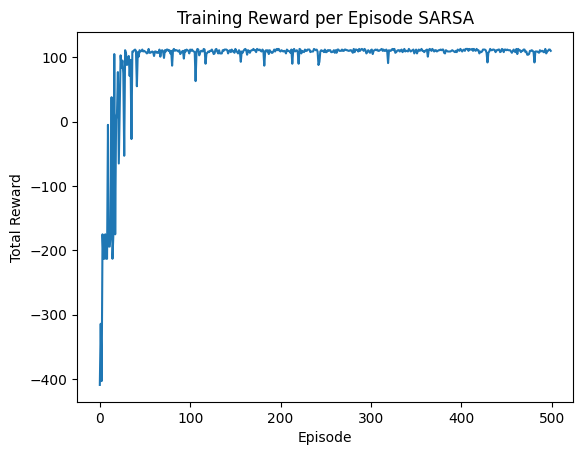

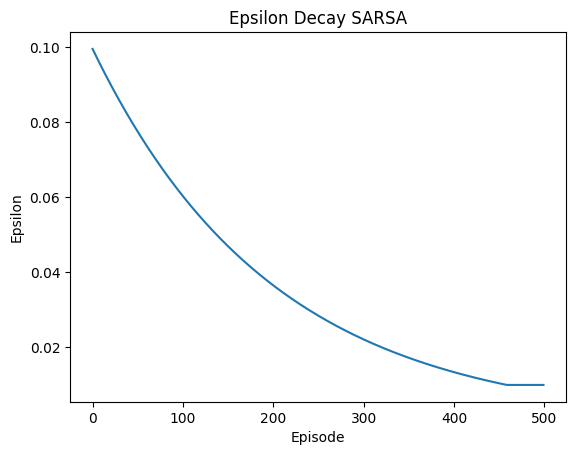

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 109
Greedy Episode 3 total reward: 110
Greedy Episode 4 total reward: 111
Greedy Episode 5 total reward: 111
Greedy Episode 6 total reward: 111
Greedy Episode 7 total reward: 110
Greedy Episode 8 total reward: 112
Greedy Episode 9 total reward: 110
Greedy Episode 10 total reward: 109


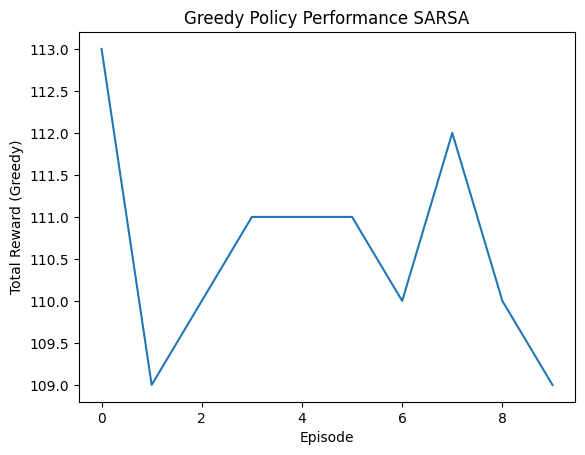


Rendering one full greedy episode SARSA:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
R # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
R . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . R # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . R . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . R . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . R D

. . . . .

In [10]:
Q = defaultdict(lambda: np.zeros(n_actions))
rewards_per_episode ,epsilons = train_loop_SARSA(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table SARSA(first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table8.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode SARSA")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay SARSA")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance SARSA")
plt.show()

print("\nRendering one full greedy episode SARSA:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

SARSA on Deterministic

SARSA Training finished.
Average reward SARSA: 104.62

Trained Q-table SARSA(first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [  -2.17913699   -2.11162787  203.1851345  1516.90522684   31.84013682
   -2.03321545]
(np.int8(1), np.int8(0), np.int8(0)): [-1.57085751 -1.41497452 -1.6420078  -3.8        -1.60217436 -1.63697806]
(np.int8(0), np.int8(1), np.int8(0)): [  29.27640497  346.53187677  164.38469552 1714.16779342  120.19052484
   74.74248087]
(np.int8(2), np.int8(0), np.int8(0)): [-0.85451585 -0.83181873 -0.79337314  0.11637773 -0.81586213 -0.89591325]
(np.int8(3), np.int8(0), np.int8(0)): [-0.55662233 -0.56220856 -0.6684457  -0.62944809 -0.67587677 -0.58686246]
(np.int8(2), np.int8(1), np.int8(0)): [-3.8        -0.3886381  -0.43559465  7.793214   -0.47425347 -0.39040228]
(np.int8(3), np.int8(1), np.int8(0)): [-0.39939238 -0.47381526 -0.4138346  -0.48568258 -0.58223259 -0.59397773]
(np.int8(4), np.int8(0), np.int8(0)): [-0.53172137 -0.47292435 -0.56901472 -0.49467268 -0.57086

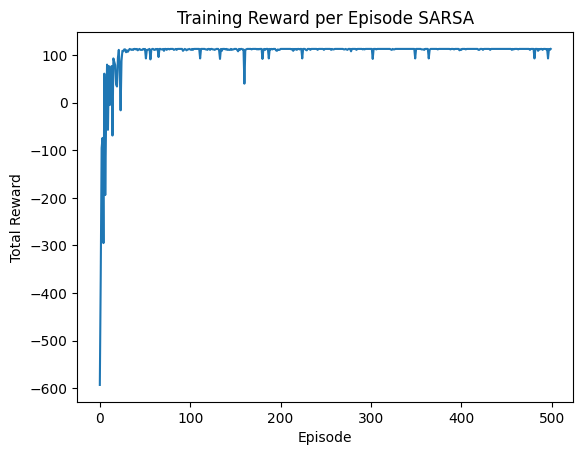

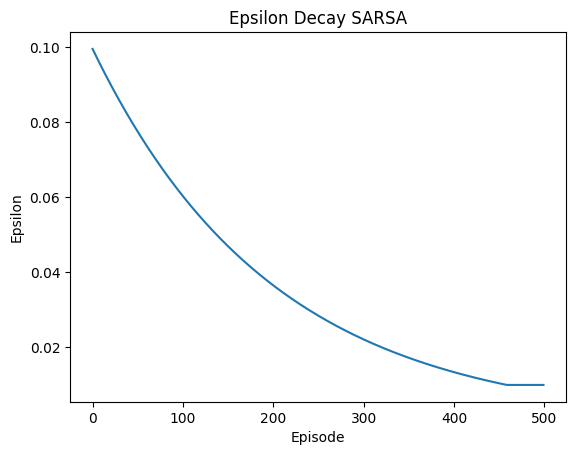

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


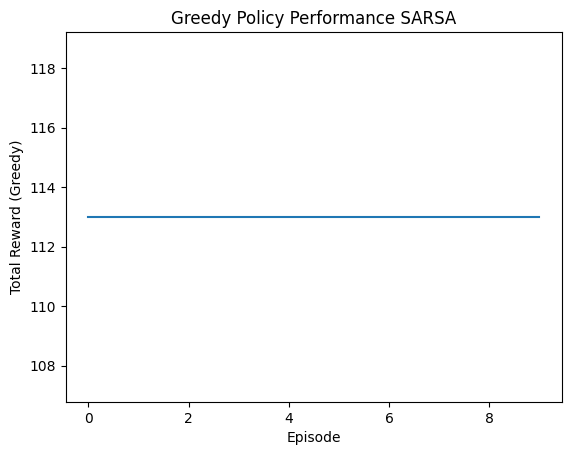


Rendering one full greedy episode SARSA:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode f

In [11]:
Q = defaultdict(lambda: np.zeros(n_actions))
env = WarehouseRobotEnv()
rewards_per_episode ,epsilons = train_loop_SARSA(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table SARSA(first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table9.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode SARSA")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay SARSA")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance SARSA")
plt.show()

print("\nRendering one full greedy episode SARSA:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- DQ on Stochastic Env


DQTraining finished.
Average reward DQ: -25.42

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [  -2.17913699   -2.11162787  203.1851345  1516.90522684   31.84013682
   -2.03321545]
(np.int8(1), np.int8(0), np.int8(0)): [-1.57085751 -1.41497452 -1.6420078  -3.8        -1.60217436 -1.63697806]
(np.int8(0), np.int8(1), np.int8(0)): [  29.27640497  346.53187677  164.38469552 1714.16779342  120.19052484
   74.74248087]
(np.int8(2), np.int8(0), np.int8(0)): [-0.85451585 -0.83181873 -0.79337314  0.11637773 -0.81586213 -0.89591325]
(np.int8(3), np.int8(0), np.int8(0)): [-0.55662233 -0.56220856 -0.6684457  -0.62944809 -0.67587677 -0.58686246]
(np.int8(2), np.int8(1), np.int8(0)): [-3.8        -0.3886381  -0.43559465  7.793214   -0.47425347 -0.39040228]
(np.int8(3), np.int8(1), np.int8(0)): [-0.39939238 -0.47381526 -0.4138346  -0.48568258 -0.58223259 -0.59397773]
(np.int8(4), np.int8(0), np.int8(0)): [-0.53172137 -0.47292435 -0.56901472 -0.49467268 -0.57086446 -0.58036

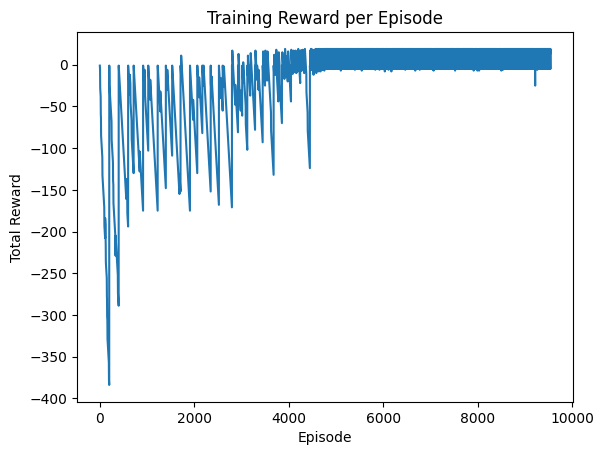

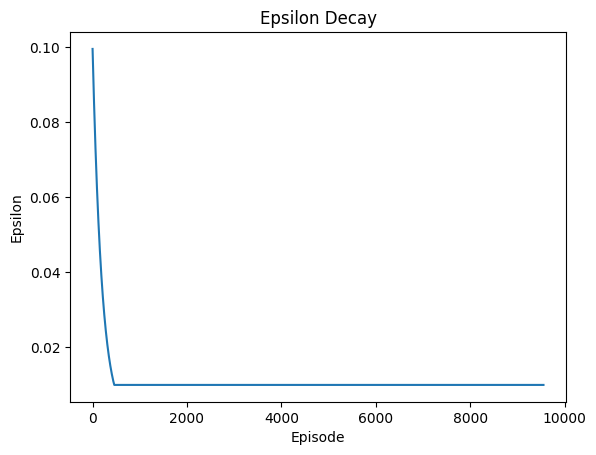

Greedy Episode 1 total reward: 113
Greedy Episode 2 total reward: 113
Greedy Episode 3 total reward: 113
Greedy Episode 4 total reward: 113
Greedy Episode 5 total reward: 113
Greedy Episode 6 total reward: 113
Greedy Episode 7 total reward: 113
Greedy Episode 8 total reward: 113
Greedy Episode 9 total reward: 113
Greedy Episode 10 total reward: 113


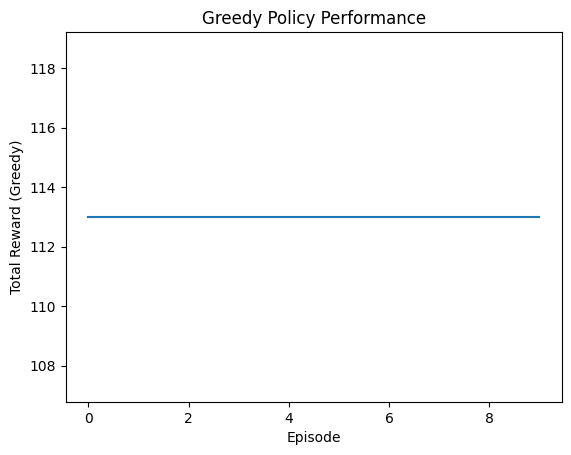


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P R .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . R
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # R
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . R
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . R

Episode finishe

In [12]:
rewards_per_episode ,epsilons = train_loop_DQ(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table10.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

-Monte Carlo on Stochastic Env


Monte Carlo training finished.
Average reward MC: -1698.05

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [ -99.90790579  -99.70080052 -115.75650284  -93.18846998  -98.53804172
  -99.89020938]
(np.int8(1), np.int8(0), np.int8(0)): [ -99.03946193 -124.54695718 -102.04639979 -118.65509095 -102.11833029
 -102.3377077 ]
(np.int8(0), np.int8(1), np.int8(0)): [-141.57537609 -633.74853255 -100.93427037   44.72781808 -119.20953397
 -135.18793626]
(np.int8(2), np.int8(0), np.int8(0)): [-100.07079582 -104.3300292  -111.21428831 -273.5750115  -490.97388789
 -106.77336857]
(np.int8(3), np.int8(0), np.int8(0)): [-101.83138458 -120.16066388 -110.26130667 -105.99609684 -100.34525234
 -157.81650373]
(np.int8(2), np.int8(1), np.int8(0)): [-536.194866   -140.70151523 -157.6500858  -220.86071664 -117.19315662
 -185.52929219]
(np.int8(3), np.int8(1), np.int8(0)): [-133.83058326 -103.62361307 -114.44620819 -102.08655442 -107.34149379
 -109.30070452]
(np.int8(4), np.int8(0), np.in

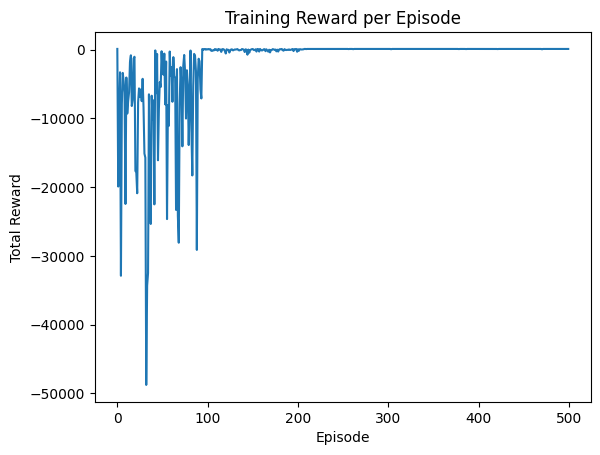

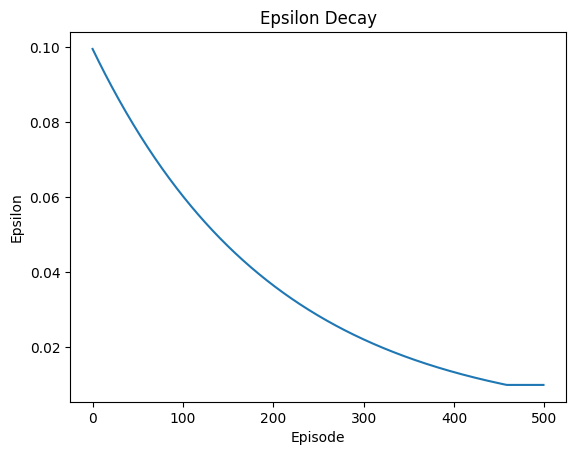

Greedy Episode 1 total reward: 109
Greedy Episode 2 total reward: 109
Greedy Episode 3 total reward: 109
Greedy Episode 4 total reward: 109
Greedy Episode 5 total reward: 109
Greedy Episode 6 total reward: 109
Greedy Episode 7 total reward: 109
Greedy Episode 8 total reward: 109
Greedy Episode 9 total reward: 109
Greedy Episode 10 total reward: 109


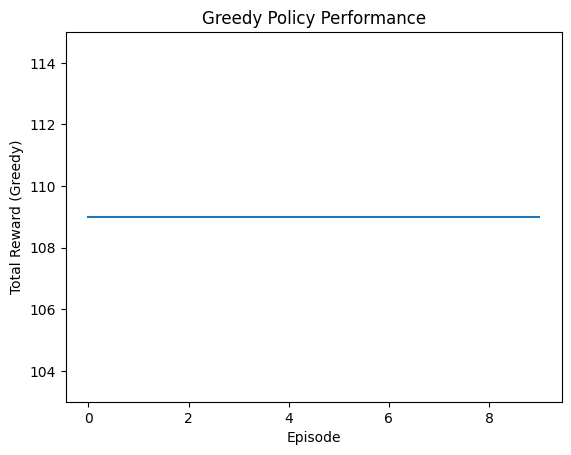


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. R . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. R . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . R . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. #

In [13]:
rewards_per_episode ,epsilons = train_loop_MC(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table11.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")

- 3 Step Bootstrapping on Stochastic Env


3-step bootstrapping training finished.
Average reward 3-step bootstrapping: 104.77

Trained Q-table (first 10 states):
(np.int8(0), np.int8(0), np.int8(0)): [-25.55810386 -15.10439372 -32.84784869  94.57822335  15.89800907
   4.8486902 ]
(np.int8(1), np.int8(0), np.int8(0)): [  -2.7268713  -124.54695718 -102.04639979 -102.17106375 -102.11833029
 -102.3377077 ]
(np.int8(0), np.int8(1), np.int8(0)): [ -62.05937476 -304.29123693  -24.53894644   96.29393501  -35.08843944
    4.85204958]
(np.int8(2), np.int8(0), np.int8(0)): [ -82.1976375  -104.3300292  -111.21428831 -273.5750115  -490.97388789
 -106.77336857]
(np.int8(3), np.int8(0), np.int8(0)): [-101.83138458 -120.16066388 -110.26130667 -105.99609684 -100.34525234
 -157.81650373]
(np.int8(2), np.int8(1), np.int8(0)): [-460.12400699 -128.31572058 -133.49446946 -206.35394569  -99.99957494
 -185.52929219]
(np.int8(3), np.int8(1), np.int8(0)): [-133.83058326 -103.62361307 -114.44620819  -99.42910759 -107.34149379
 -109.30070452]
(np.int8(4)

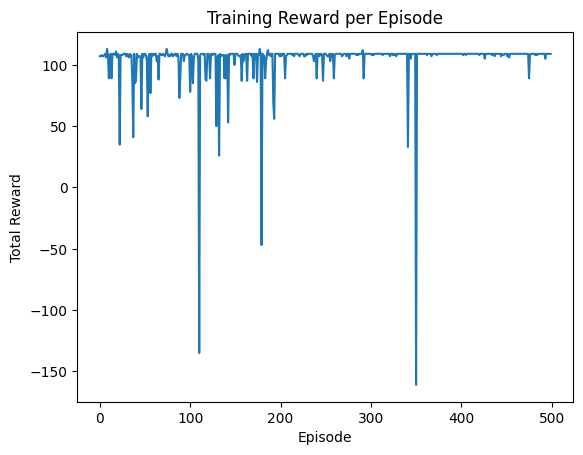

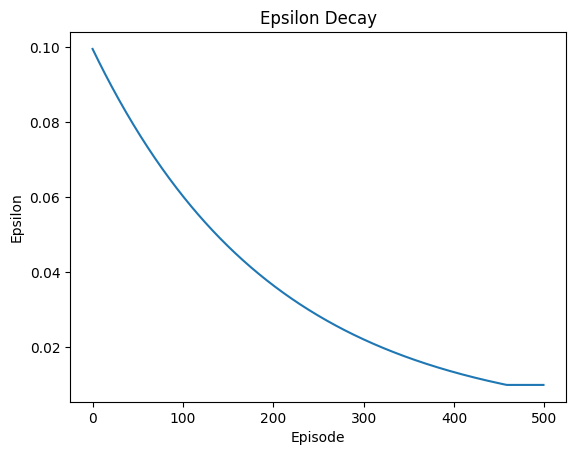

Greedy Episode 1 total reward: 109
Greedy Episode 2 total reward: 109
Greedy Episode 3 total reward: 109
Greedy Episode 4 total reward: 109
Greedy Episode 5 total reward: 109
Greedy Episode 6 total reward: 109
Greedy Episode 7 total reward: 109
Greedy Episode 8 total reward: 109
Greedy Episode 9 total reward: 109
Greedy Episode 10 total reward: 109


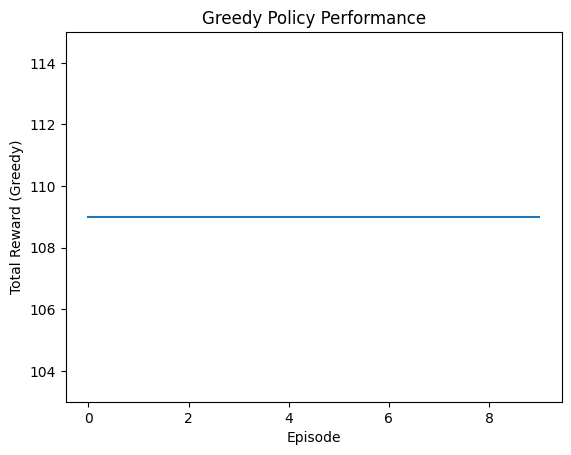


Rendering one full greedy episode:
R . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. R . . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . R . . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . R . .
. # # . . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # R . .
. . . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . R . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . R P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. R . P . .
. . . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. R . . # .
. . . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. R . . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . R . . .
. . . . . D

. . . . . .
. # # . . .
. . . P . .
. . . . # .
. . . R . .
. . . . . D

. . . . . .
. #

In [15]:
rewards_per_episode ,epsilons = train_loop_3SB(episodes, max_steps, alpha, gamma, epsilon, epsilon_decay, epsilon_min)

print("\nTrained Q-table (first 10 states):")
for state in list(Q.keys())[:10]:
    print(f"{state}: {Q[state]}")

with open("Q_table12.pkl", "wb") as f:
    pickle.dump(dict(Q), f)

plt.figure()
plt.plot(rewards_per_episode)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Reward per Episode")
plt.show()

plt.figure()
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Epsilon Decay")
plt.show()

greedy_rewards = test_loop()

plt.figure()
plt.plot(greedy_rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward (Greedy)")
plt.title("Greedy Policy Performance")
plt.show()

print("\nRendering one full greedy episode:")
obs, _ = env.reset()
state = tuple(obs)
done = False
env.render()
while not done:
    action = np.argmax(Q[state])
    next_obs, reward, done, _, _ = env.step(action)
    state = tuple(next_obs)
    env.render()
print("Episode finished.\n")